# Check annotations
#### Author: Rimple Sandhu

In [110]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
from matplotlib import animation

In [112]:
#from resampling_kalman import *
from annotation_3dep import *
from annotation_hrrr import *
from telemetry_module import *

In [4]:
data_dir = os.path.join(os.path.abspath(os.path.curdir), 'data')
telemetry_dir = os.path.join(os.path.abspath(os.path.curdir), 'output', 'telemetry')
dep3_dir = os.path.join(os.path.abspath(os.path.curdir), 'output', 'dep3')
hrrr_dir = os.path.join(os.path.abspath(os.path.curdir), 'output', 'hrrr_nc')
output_dir = os.path.join(os.path.abspath(os.path.curdir), 'output')
fig_dir = os.path.join(os.path.abspath(os.path.curdir), 'figs')

In [5]:
# load data
fpath = os.path.join(telemetry_dir, 'df_variable_rate.pkl')
vdf = pd.read_pickle(fpath)
sort_according_to_columns(vdf, ['Group','AnimalID','TimeLocal'])
print_memory_usage(vdf, by='Group')

b'hr' = 97.64 MB, 389306 rows, 1604353 nans
b'pa' = 149.18 MB, 594760 rows, 11273171 nans
b'wy' = 892.0 MB, 3556385 rows, 37233301 nans
Total memory = 1138.82 MB


In [6]:
# fpath = os.path.join(telemetry_dir, 'df_constant_rate_1s.pkl')
# cdf = pd.read_pickle(fpath)
# sort_according_to_columns(cdf, ['Group','AnimalID','TimeLocal'])
# print_memory_usage(cdf, by='Group')
# #cdf = convert_bytes_to_strings(cdf)

In [7]:
resampling = rasterio.enums.Resampling.bilinear
usa = gpd.read_file(os.path.join(data_dir, 'maps', 'usa_states', 'cb_2018_us_state_20m.shp'))

In [8]:
ds_hrrr = xr.open_mfdataset(os.path.join(hrrr_dir, f'hrrr_2022-04-13T*.nc'))
hrrr_crs = ds_hrrr.gribfile_projection.attrs['crs_wkt']
ds_hrrr['WindSpeed_80m'] = np.sqrt(ds_hrrr['WindSpeedU_80m']**2 + ds_hrrr['WindSpeedV_80m']**2)
ds_hrrr['WindSpeed_10m'] = np.sqrt(ds_hrrr['WindSpeedU_10m']**2 + ds_hrrr['WindSpeedV_10m']**2)
ds_hrrr['WindDirection_80m'] = get_direction(ds_hrrr['WindSpeedU_80m'], ds_hrrr['WindSpeedV_80m'])
ds_hrrr['WindShear'] = ds_hrrr['WindSpeed_10m'] - ds_hrrr['WindSpeed_80m']
kin_heat_flux = ds_hrrr['SensibleHeatFlux'] * ds_hrrr['Temperature_0m'] / ds_hrrr['PressureSurface']
ds_hrrr['DeardoffSpeed'] = (9.8 * ds_hrrr['BoundaryLayerHeight'] * kin_heat_flux / ds_hrrr['Temperature_0m'])**(1 / 3)
temp_diff = ds_hrrr['Temperature_2m'] - ds_hrrr['Temperature_0m']
ds_hrrr['BulkRichardsonNumber'] = 9.8 * 1. * temp_diff / (ds_hrrr['Temperature_0m'] * ds_hrrr['WindSpeed_10m'])

In [9]:
ds_hrrr.time

<xarray.DataArray 'time' (time: 14)>
array(['2022-04-13T00:00:00.000000000', '2022-04-13T01:00:00.000000000',
       '2022-04-13T02:00:00.000000000', '2022-04-13T03:00:00.000000000',
       '2022-04-13T14:00:00.000000000', '2022-04-13T15:00:00.000000000',
       '2022-04-13T16:00:00.000000000', '2022-04-13T17:00:00.000000000',
       '2022-04-13T18:00:00.000000000', '2022-04-13T19:00:00.000000000',
       '2022-04-13T20:00:00.000000000', '2022-04-13T21:00:00.000000000',
       '2022-04-13T22:00:00.000000000', '2022-04-13T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time                 (time) datetime64[ns] 2022-04-13 ... 2022-04-13T23:0...
    gribfile_projection  float64 nan

In [10]:
subdomains = {}
for key in vdf['Group'].unique():
    idf = vdf.loc[vdf['Group'] == key, vdf.columns]
    print(f'{key} = ', end="")
    subdomains[key] = partition_region_into_blocks(
        x_data=idf['Longitude'],
        y_data=idf['Latitude'],
        x_width=0.2,  # DONT CHANGE THIS, WILL OVERWRITE DOWNLOADED DATA
        y_width=0.2  # DONT CHANGE THIS, WILL OVERWRITE DOWNLOADED DATA
    )


b'hr' = 90/1508 blocks have data
b'pa' = 550/891 blocks have data
b'wy' = 585/975 blocks have data


In [113]:
group_id = b'pa'
domain_id =379
cname = 'dem'
CSG_PROJ_CRS = 'ESRI:102008'
filepath = os.path.join(dep3_dir, group_id.decode(), f'tile_{domain_id}', f'{cname}.tif')
ds_3dep_geo = rio.open_rasterio(filepath).to_dataset(name=cname).squeeze()
ds_3dep = ds_3dep_geo.rio.reproject(rio.crs.crs_from_user_input(CSG_PROJ_CRS), 
                                    resolution=10., nodata=np.nan, Resampling=resampling)
#ds_3dep = ds_3dep.to_dataset(name='dem').squeeze()
#ds_3dep = ds_3dep.rename({'x':'Longitude', 'y':'Latitude', 'dem':'GroundElevation'})
#ds_3dep = ds_3dep.transpose()
slope = calcSlopeDegrees(ds_3dep['dem'].values, res=10.)
aspect = calcAspectDegrees(ds_3dep['dem'].values, res=10.)
ds_3dep['Slope'] = (('y', 'x'), slope)
ds_3dep['Aspect'] = (('y', 'x'), aspect)
#ds_3dep['Slope'] = (('x', 'y'), slope)
#ds_3dep['Aspect'] = (('x', 'y'), aspect)
xx, yy = np.meshgrid(ds_3dep.x, ds_3dep.y, indexing='xy')

In [114]:
lonlat_bounds = subdomains[group_id][domain_id]
key_bool = vdf['Group'] == group_id
lon_bool = vdf['Longitude'].between(lonlat_bounds[0], lonlat_bounds[2])
lat_bool = vdf['Latitude'].between(lonlat_bounds[1], lonlat_bounds[3])
final_bool = (lon_bool) & (lat_bool) & (key_bool)
x_data = vdf.loc[final_bool, 'X'].values
y_data = vdf.loc[final_bool, 'Y'].values

In [115]:
lonlat_bounds

(-76.68619608561198, 40.579300554063586, -76.48638167872573, 40.77909657796224)

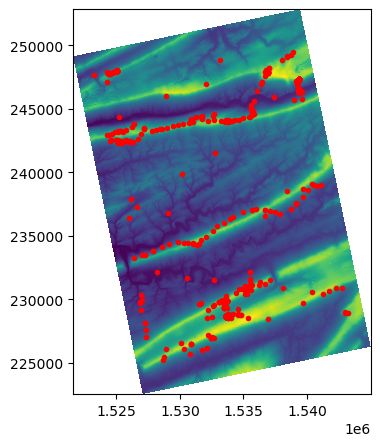

In [116]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(xx, yy, ds_3dep.dem.values)
ax.set_aspect('equal')
ax.plot(x_data, y_data, '.r')
#ds_3dep.dem.plot()

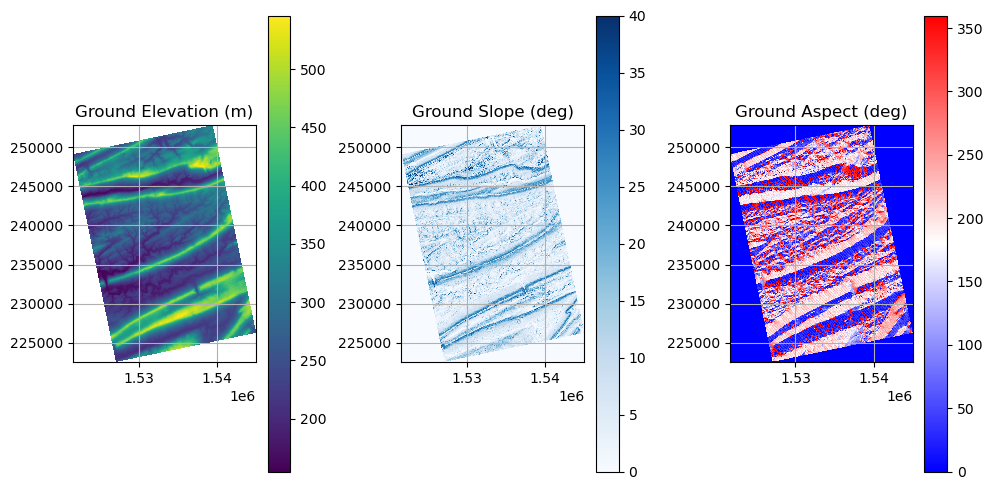

In [117]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
cm = ax[0].pcolormesh(xx, yy, ds_3dep['dem'], cmap='viridis')
plt.colorbar(cm, ax=ax[0])
ax[0].set_title('Ground Elevation (m)')
ax[0].set_aspect('equal')
ax[0].grid(True)
cm = ax[1].pcolormesh(xx, yy, ds_3dep['Slope'], cmap='Blues', vmax=40)
plt.colorbar(cm, ax=ax[1])
ax[1].set_title('Ground Slope (deg)')
ax[1].set_aspect('equal')
ax[1].grid(True)
cm = ax[2].pcolormesh(xx, yy, ds_3dep['Aspect'], cmap='bwr',)
plt.colorbar(cm, ax=ax[2])
ax[2].set_title('Ground Aspect (deg)')
ax[2].set_aspect('equal')
ax[2].grid(True)
# ds_3dep_geo['Slope'].plot(ax=ax[1])
# ds_3dep_geo['Aspect'].plot(ax=ax[2])
# for iax in ax:
#     iax.axis(False)
fig.tight_layout()
#fig.savefig(os.path.join(fig_dir,f'terrain_3dep.png'), dpi=100)

In [118]:
ds_3dep.Aspect.sel(x=1490000, y=270000, method='nearest').values

array(0., dtype=float32)

Computing orograhpic updraft with vector model
Computing orograhpic updraft with vector model
Computing orograhpic updraft with vector model


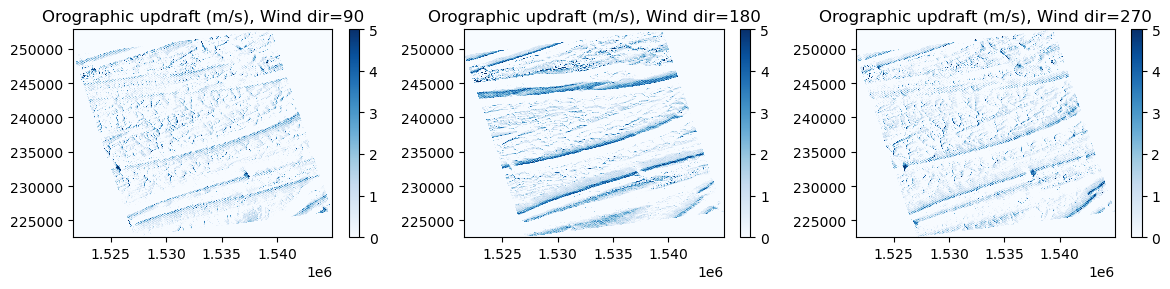

In [120]:
from ssrs.layers import calcOrographicUpdraft_original
fig, ax = plt.subplots(1,3,figsize=(12,3))
for i, wind_dir in enumerate([90, 180, 270]):
    updraft = calcOrographicUpdraft_original(
            wspeed = np.full(ds_3dep.dem.shape, 10.),
            wdirn= np.full(ds_3dep.dem.shape, wind_dir),
            slope= ds_3dep.Slope.values,
            aspect= ds_3dep.Aspect.values,
            res_terrain = 10., # high-res terrain data resolution
            res = 10.,         # low-res analysis resolution
            min_updraft_val = 1e-5
        )
    cm = ax[i].pcolormesh(xx, yy, updraft, cmap='Blues', vmin=0, vmax=5)
    #ax[i].axis(False)
    plt.colorbar(cm, ax=ax[i])
    ax[i].set_title(f'Orographic updraft (m/s), Wind dir={wind_dir}')
fig.tight_layout()
#fig.savefig(os.path.join(fig_dir,f'updrafts.png'), dpi=100)

In [100]:
import scipy.signal as ssg
zz = np.zeros((100,150))
zz[50,50] = 1.
zz[60,60] = 1.
#zz[0,0] = 1.
zz[99,149] = 1.
krad=20
kernel = np.zeros((2 * krad + 1, 2 * krad + 1))
y, x = np.ogrid[-krad:krad + 1, -krad:krad + 1]
mask2 = x**2 + y**2 <= krad**2
#mask2 = x + y <= krad
kernel[mask2] = 1.
kernel /= np.sum(kernel)
zzn = ssg.convolve2d(zz, kernel, mode='same')*1000
x = np.linspace(10,20,zzn.shape[1])
y = np.linspace(0,5,zzn.shape[0])
dr = xr.DataArray(coords = {'y':y,'x':x}, data=zzn)
xx, yy = np.meshgrid(dr.x, dr.y, indexing='xy')
zzn_slope = calcAspectDegrees(dr.values, res=1)

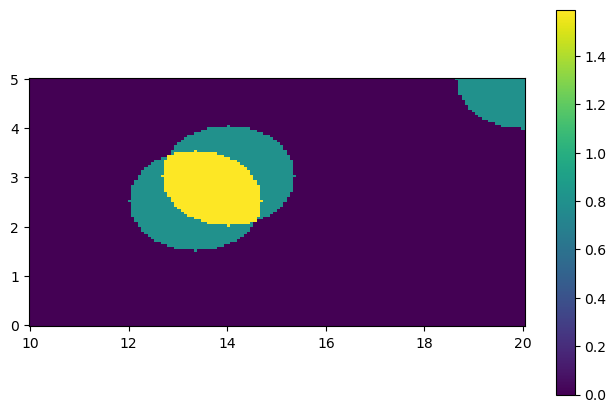

In [101]:
fig, ax = plt.subplots(figsize=(8,5))
cm = ax.pcolormesh(x, y, zzn)
ax.set_aspect('equal')
fig.colorbar(cm,ax=ax)

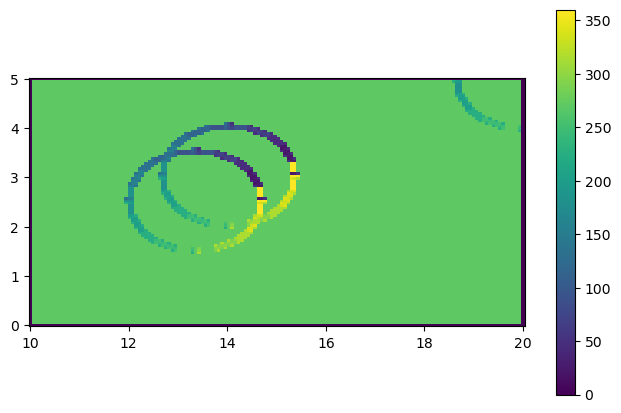

In [102]:
fig, ax = plt.subplots(figsize=(8,5))
cm = ax.pcolormesh(xx, yy, zzn_slope)
ax.set_aspect('equal')
fig.colorbar(cm,ax=ax)

In [85]:
np.amin(zzn_slope)

0.0

In [ ]:
dsr, ds = get_terrain_data_for_this_domain('pa', 20, data_dir = dep3_dir, plot=False)

In [ ]:
center_x = ds.x.mean()
center

In [ ]:
center_x, center_y = transform_coordinates(
        in_crs='EPSG:4326',
        out_crs=hrrr_crs,
        in_x=[center_lon],
        in_y=[center_lat]
    )
    grid_size = int(width_km * 1000. / resolution_m)
    xgrid = np.linspace(center_x[0] - width_km * 1000. / 2.,
                        center_x[0] + width_km * 1000. / 2., grid_size + 1)
    ygrid = np.linspace(center_y[0] - width_km * 1000. / 2.,
                        center_y[0] + width_km * 1000. / 2., grid_size + 1)
    ds_interp = ds.interp(
        y=ygrid,
        x=xgrid,
        time=itime,
        method='linear',
        kwargs={'fill_value': 'extrapolate'}
    )

In [ ]:
dsr.dem.plot()

In [ ]:
slope = calcSlopeDegrees(dsr['dem'].values, res=10.)
aspect = calcAspectDegrees(dsr['dem'].values, res=10.)
dsr['Slope'] = (('y', 'x'), slope)
dsr['Aspect'] = (('y', 'x'), aspect)

In [ ]:
dsr.Aspect.plot()

In [ ]:
from ssrs.layers import calcOrographicUpdraft_original
updraft = calcOrographicUpdraft_original(
        wspeed = np.full(ds.dem.shape, 5.),
        wdirn= np.full(ds.dem.shape, 299.),
        slope= ds.Slope,
        aspect= ds.Aspect,
        res_terrain = 10., # high-res terrain data resolution
        res = 10.,         # low-res analysis resolution
        min_updraft_val = 1e-5
    )

In [ ]:
updraft.plot()

In [ ]:
track_id = 14
vdftrack = vdf[vdf['TrackID']==14]
cdftrack = cdf[cdf['TrackID']==14]
fig, ax = plt.subplots(figsize=(6,6))
cm1 = ax.scatter(vdftrack['X'], vdftrack['Y'], c=vdftrack['AltitudeAGL'], s=1, cmap='viridis')
# cbar, _ = create_gis_axis_new(fig, ax, cm1, km_bar=0.1)
# cbar.set_label('Altitude AGL (m)')
# #ax.scatter(tdf.X, tdf.Y, marker='1', color='k', s=100, alpha=1, linewidth=2)
# #_, _ = create_gis_axis_new(fig, ax, None, km_bar=km_bar)
# #ax.plot(odf.X, odf.Y, '.k', markersize=1, alpha=0.99, label='Telemetry data')
# put_start_end_text(ax, simdf, lag=1, fsize=8)
# #ax.set_xlim(extent[:2])
# #ax.set_ylim(extent[2:])
# fig.tight_layout()
# fig.savefig(os.path.join(output_fig_dir,f'sim_track.png'), dpi=400)

In [ ]:
cdf['SpeedHor'].hist(bins=100, range=(0,30), density=True)
vdf[vdf['TrackID']>0]['SpeedHor'].hist(bins=100, range=(0,30), density=True)
vdf[vdf['TrackID']>0]['SpeedHorUnit'].hist(bins=100, range=(0,30), density=True)

In [ ]:
vdf.dtypes

In [ ]:
idf = cdf[cdf['TrackID'] == 2].iloc[:30]
jdf = vdf[vdf['TrackID'] == 2].iloc[:20]
plt.plot(idf['X'], idf['Y'])
plt.plot(jdf['X'], jdf['Y'])
plt.plot(idf['X'].iloc[0], idf['Y'].iloc[0],'*g')

In [ ]:
jdf['HeadingHor'], idf['HeadingHor']

In [ ]:
vdf['HeadingHor'].iloc[123400:123410], vdf['HeadingHorUnit'].iloc[123400:123410]

In [ ]:
cdf['HeadingHor'].hist(bins=100)

In [ ]:
vdf['HeadingHor'].hist(bins=100)

In [ ]:
vdf_track = vdf[vdf['TrackID']==1]
cdf_track = resample_telemetry_track(vdf_track)
vdf_track2 = vdf[vdf['TrackID']==2]
cdf_track2 = resample_telemetry_track(vdf_track2)

In [ ]:
rdf = pd.concat([cdf_track, cdf_track2], axis=0)

In [ ]:
rdf.Group.unique()

In [ ]:
fpath = os.path.join(telemetry_dir, 'df_constant_rate_1s.pkl')
sdf = pd.read_pickle(fpath)
sort_according_to_columns(sdf, ['Group','AnimalID','TimeLocal'])
sdf['Sex'] = sdf['Sex'].str.decode("utf-8")
sdf['Age'] = sdf['Age'].str.decode("utf-8")
sdf['Group'] = sdf['Group'].str.decode("utf-8")
print_memory_usage(sdf, by='Group')

In [ ]:
from ssrs.raster import transform_coordinates

In [ ]:
CSG_CRS = 'ESRI:102008'
GEO_CRS = 'EPSG:4326'
xlocs, ylocs = transform_coordinates(CSG_CRS, GEO_CRS,  sdf['X'].values, sdf['Y'].values)

In [ ]:
sdf.columns

In [ ]:
sdf.shape

In [ ]:
sdf['SpeedHor'] = np.sqrt(sdf['SpeedX']**2 + sdf['SpeedY']**2)
sdf['Heading'] = np.degrees(np.arctan2(sdf['SpeedX'], sdf['SpeedY']))
sdf['Xahead_50m_0Deg'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading']))
sdf['Yahead_50m_0Deg'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading']))
sdf['Xahead_50m_45DegRight'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] + 10.))
sdf['Yahead_50m_45DegRight'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] + 10.))
sdf['Xahead_50m_45DegLeft'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] - 10.))
sdf['Yahead_50m_45DegLeft'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] - 10.))
sdf['Xahead_50m_10DegRight'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] + 10.))
sdf['Yahead_50m_10DegRight'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] + 10.))
sdf['Xahead_50m_10DegLeft'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] - 10.))
sdf['Yahead_50m_10DegLeft'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] - 10.))

In [ ]:
sdf.Heading.describe()

In [ ]:
sdf.columns

In [ ]:
sdf.loc[sdf['TrackPointCount'] < 6*60, 'TrackID'].unique()

In [ ]:
df[df['Group']=='wy'].AnimalID.nunique()

In [ ]:
track_id = 18
idf = sdf[sdf['TrackID'] == track_id]
fdf = df[df['TrackID'] == track_id]
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(idf['X'], idf['Y'], '-r', label="Track")
ax.plot(fdf['X'], fdf['Y'], '*k', label="Track", markersize=2)
# ax.plot(idf['Xahead_50m_0Deg'], idf['Yahead_50m_0Deg'], '-b', label="50 m in direction")
# ax.plot(idf['Xahead_50m_45DegRight'], idf['Yahead_50m_45DegRight'], '-g', label="50 m, 45 deg to the right")
# ax.plot(idf['Xahead_50m_45DegLeft'], idf['Yahead_50m_45DegLeft'], '-k', label="50 m, 45 deg to the left")
# ax.plot(idf['Xahead_50m_45DegRight'], idf['Yahead_50m_45DegRight'], '-g', label="50 m, 45 deg to the right")
# ax.plot(idf['Xahead_50m_45DegLeft'], idf['Yahead_50m_45DegLeft'], '-k', label="50 m, 45 deg to the left")
# #ax.plot(idf['Xahead_50m_0deg'], idf['Yahead_50m_0deg'], '-r', label="50 m in direction")
# ax.legend()

In [ ]:
rdf['X'].hist(bins=100)

In [ ]:
# lis of covariates
# look ahead points at
# - 50 m in direction
# - 50 m 45 deg either side
# - 50 m or 100m , 45 deg or 10 deg
# - groundelevation, slope and aspect - 3dep 10m
# - wind speed at 80 m
# - updrafts, deardoff

In [ ]:

relevant_cols = ['Group', 'X', 'Y', 'Altitude', 'TrackTimeElapsed', 'TrackID', 
                'VDOP','HDOP', 'TimeUTC', 'TimeLocal', 'Age', 'AnimalID', 'Sex']

list_of_sdfs = []
for track_id in [1,2,3]:
    idftrack = df.loc[df['TrackID']==track_id, relevant_cols]
    sdf =  resample_telemetry_track(
        idftrack, 
        dt = 1.,
        dim_colnames = ['Altitude', 'X', 'Y'],
        dop_colnames = ['VDOP', 'HDOP', 'HDOP'],
        dop_factors = [4.5, 2.5*np.sqrt(2), 2.5*np.sqrt(2)],
        dim_model_errors = [0.02, 0.5, 0.5],
        drop_variances = True,
        drop_metrics = True
    )
    list_of_sdfs.append(sdf)

In [ ]:
sdf = pd.concat(list_of_sdfs, axis=0)

In [ ]:
for idf in list_of_sdfs:
    print(idf.shape)
sdf.shape

In [ ]:
list_of_track_dfs = [df[df['TrackID'] == ix] for ix in df.TrackID.unique() if ix > 0]

In [ ]:
df.TrackID.nunique(), len(list_of_track_dfs)

In [ ]:
sdf['SpeedHor'] = np.sqrt(sdf['SpeedX']**2 + sdf['SpeedY']**2)
sdf['Heading'] = np.arctan2(sdf['SpeedX'], sdf['SpeedY']))
sdf['Xahead_50m_0deg'] = sdf['X'] + 50.*np.sin(sdf['Heading'])
sdf['Yahead_50m_0deg'] = sdf['Y'] + 50.*np.cos(sdf['Heading'])


In [ ]:
from annotation_hrrr import *

In [ ]:
DICT_OF_HRRR_VARS

In [ ]:
sdf =  resample_telemetry_track(
    idftrack, 
    dt = 1.,
    dim_colnames = ['Altitude', 'X', 'Y'],
    dop_colnames = ['VDOP', 'HDOP', 'HDOP'],
    dop_factors = [4.5, 2.5*np.sqrt(2), 2.5*np.sqrt(2)],
    dim_model_errors = [0.02, 0.25, 0.25],
    drop_variances = True,
    drop_metrics = True
)

In [ ]:
sdf.columns

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(idftrack['TrackTimeElapsed'], idftrack['X'])
ax.plot(sdf['TrackTimeElapsed'], sdf['X'])

In [ ]:
list(zip(list_of_times,list_of_obs))

In [ ]:

"""
tobs = df_obs['TrackTimeElapsed'].values
    list_of_obs = list(df_obs[var_name].values)

newdf['TimeUTC'] = pd.date_range(
        start=df_obs['TimeUTC'].iloc[0], periods=len(newdf), freq=str(delta_t) + "S")
    newdf['TimeLocal'] = pd.date_range(
        start=df_obs['TimeLocal'].iloc[0], periods=len(newdf), freq=str(delta_t) + "S")
    newdf['TrackID'] = track_id
    if plot == True:
        fig, ax = plt.subplots(3, 1, figsize=(12, 4))
        ax[0].plot(tobs, df_obs[var_name], '+r',
                   label='Telemetry', markersize=2.)
        for i, iname in enumerate(motion_model.labels):
            ax[i].plot(newdf['TimeElapsed'], newdf[iname],
                       '-b', label='Resampled')
        ax[0].legend()
    newdf = ikf.df_smoother[ikf.labels + ['TimeElapsed']]
"""


In [ ]:
def get_resampled_track(idftrack):
    assert len(idf['TrackID'].unique()) == 1, 'Track id has to be unique'
    idf1 = kalman_smoother_ca1d(idftrack, var_name = 'Altitude', dop_name = 'VDOP', plot=False)
    idf2 = kalman_smoother_ca1d(idftrack, var_name = 'X', dop_name = 'HDOP', plot=False)
    idf3 = kalman_smoother_ca1d(idftrack, var_name = 'Y', dop_name = 'HDOP', plot=False)
    idf = pd.concat([idf1, idf2, idf3], axis=1, join='outer')
    idf = idf.loc[:,~idf.columns.duplicated()].copy()
    idf.rename(columns = {
        'Altitude_speed': 'Vspeed', 'Altitude_accn':'Vaccn',
        'X_speed': 'HspeedX', 'Y_speed':'HspeedY',
        'X_accn': 'HaccnX', 'Y_accn':'HaccnY',
        'TimeElapsed':'TrackTimeElapsed'
    }, inplace = True)
    

In [ ]:
idf = df['wy']
varnames = ['X', 'Y', 'Altitude', 'TrackTimeElapsed', 'TrackID', 'VDOP','HDOP', 'TimeUTC', 'TimeLocal']
track_id = 14
idftrack = idf.loc[idf['TrackID']==14, varnames]
idf1 = kalman_smoother_ca1d(idftrack, var_name = 'Altitude', dop_name = 'VDOP', plot=True)
idf2 = kalman_smoother_ca1d(idftrack, var_name = 'X', dop_name = 'HDOP', plot=True)
idf3 = kalman_smoother_ca1d(idftrack, var_name = 'Y', dop_name = 'HDOP', plot=True)
idf = pd.concat([idf1, idf2, idf3], axis=1, join='outer')
idf = idf.loc[:,~idf.columns.duplicated()].copy()

In [ ]:
idf.rename(columns = {
    'Altitude_speed': 'Vspeed', 'Altitude_accn':'Vaccn',
    'X_speed': 'HspeedX', 'Y_speed':'HspeedY',
    'X_accn': 'HaccnX', 'Y_accn':'HaccnY',
    'TimeElapsed':'TrackTimeElapsed'
}, inplace = True, errors='ignore')
idf.sort_index(axis=1, inplace=True)
idftrack.sort_index(axis=1, inplace=True)

In [ ]:
idf

In [ ]:
idftrack

In [ ]:
idf.dtypes